# 導入不同策略 根據最新300根k棒產生的買賣序列 進行回測 畫出圖表

,Net Profit (%),Total Closed Trades,Percent Profitable,Profit Factor,Max Drawdown,Avg Trade,Avg Win Trade,Avg Loss Trade,Avg Bars in Trade,Buy & Hold Return
metric,71.54%,300,38.00%,1.34,-16.60%,0.20%,1.80%,-0.78%,2.80,36.36%


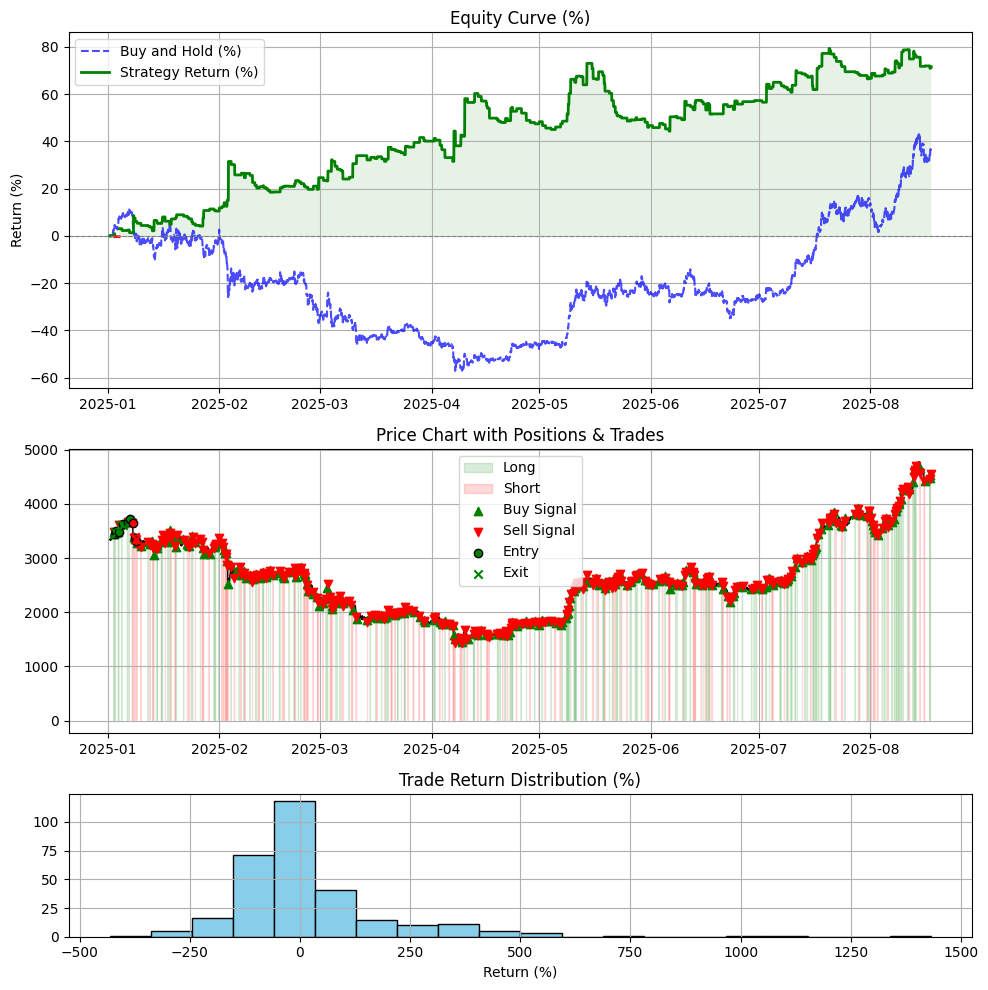

,timestamp,signal,close,reason,stop_loss
28,2025-01-02 16:00:00+08:00,1,3437.930000,多單進場,3395.095000
31,2025-01-02 19:00:00+08:00,-1,3471.180000,多單平倉,nan
32,2025-01-02 20:00:00+08:00,1,3480.480000,多單進場,3436.468000
33,2025-01-02 21:00:00+08:00,-1,3465.850000,多單平倉,nan
34,2025-01-02 22:00:00+08:00,1,3495.190000,多單進場,3451.832000
35,2025-01-02 23:00:00+08:00,-1,3463.510000,多單平倉,nan
57,2025-01-03 21:00:00+08:00,1,3481.850000,多單進場,3440.636000
64,2025-01-04 04:00:00+08:00,-1,3600.570000,多單平倉,nan
80,2025-01-04 20:00:00+08:00,1,3635.520000,多單進場,3596.448000
83,2025-01-04 23:00:00+08:00,-1,3607.810000,多單平倉,nan


In [6]:
from Technicalindicatorstrategy import vegas,turtle_strategy,macd,turtle_strategy_filter
from Backtest.backtest import backtest_signals
from Plot.plot import display_trades_log_as_html,plot_backtest_result
from IPython.display import HTML
import pandas as pd
from datetime import datetime,timedelta
import warnings 
warnings.filterwarnings('ignore')
import numpy as np
np.random.seed(42)  # ✅ 固定隨機性（可重現性）
import random
random.seed(42)

df_signals = turtle_strategy_filter.get_signals('ETHUSDT','1h',datetime.now(),5489-5)

result = backtest_signals(
    df_signals.copy(),
    initial_capital = 1000000, # 1000台幣
    fee_rate = 0.0000, # 合約手續費
    leverage = 1, # 槓桿
    allow_short = True, # 是否做空
    stop_loss = None,       # 停損閾值，例如0.05代表5%
    take_profit = None,     # 停利閾值
    capital_ratio = 1, # 每次使用的資金佔比
    max_hold_bars = 100000,# 最大持有K棒數
    delay_entry=False
    )  
display(pd.DataFrame(result['metric'],index=['metric']))
html_output = display_trades_log_as_html(result['trades_log'][:10])
plot_backtest_result(result)
display(HTML(html_output))
display(df_signals.loc[df_signals['signal']!=0,['timestamp','signal','close','reason','stop_loss']].head(10).style.background_gradient())

In [4]:
df_signals.tail(10)

,timestamp,open,high,low,close,20_high,20_low,H-L,H-PC,L-PC,ATR,MACDh,position,entry_price,stop_loss,signal,reason
5479,2025-08-17 09:00:00+08:00,4412.76,4420.81,4393.98,4406.09,4465.22,4372.54,26.83,8.05,18.78,31.8980,5.258573,0,NaN,NaN,0,
5480,2025-08-17 10:00:00+08:00,4406.10,4434.20,4398.20,4434.08,4465.22,4372.54,36.00,28.11,7.89,31.4075,6.302148,0,NaN,NaN,0,
5481,2025-08-17 11:00:00+08:00,4434.08,4459.30,4428.35,4452.77,4465.22,4372.54,30.95,25.22,5.73,31.9435,7.989977,0,NaN,NaN,0,
5482,2025-08-17 12:00:00+08:00,4452.78,4490.25,4451.98,4483.29,4459.30,4372.54,38.27,37.48,0.79,31.1600,10.729886,1,4483.29,4420.970,1,多單進場
5483,2025-08-17 13:00:00+08:00,4483.30,4491.00,4467.61,4470.55,4490.25,4372.54,23.39,7.71,15.68,32.0910,11.200379,1,4483.29,4420.970,0,
5484,2025-08-17 14:00:00+08:00,4470.55,4483.79,4455.43,4457.12,4491.00,4372.54,28.36,13.24,15.12,29.8280,10.154221,0,NaN,NaN,-1,多單平倉
5485,2025-08-17 15:00:00+08:00,4457.13,4472.43,4444.44,4467.12,4491.00,4375.63,27.99,15.31,12.68,29.1465,9.684401,0,NaN,NaN,0,
5486,2025-08-17 16:00:00+08:00,4467.12,4538.39,4458.64,4535.51,4491.00,4375.63,79.75,71.27,8.48,28.5780,13.304687,1,4535.51,4478.354,1,多單進場
5487,2025-08-17 17:00:00+08:00,4535.50,4559.00,4527.66,4543.14,4538.39,4384.39,31.34,23.49,7.85,30.7470,15.390907,1,4535.51,4478.354,0,
5488,2025-08-17 18:00:00+08:00,4543.14,4543.86,4535.35,4538.32,4559.00,4387.15,8.51,0.72,7.79,30.1375,15.576631,1,4535.51,4478.354,0,


# 停利停損最佳化

100%|██████████| 10/10 [00:25<00:00,  2.57s/it]


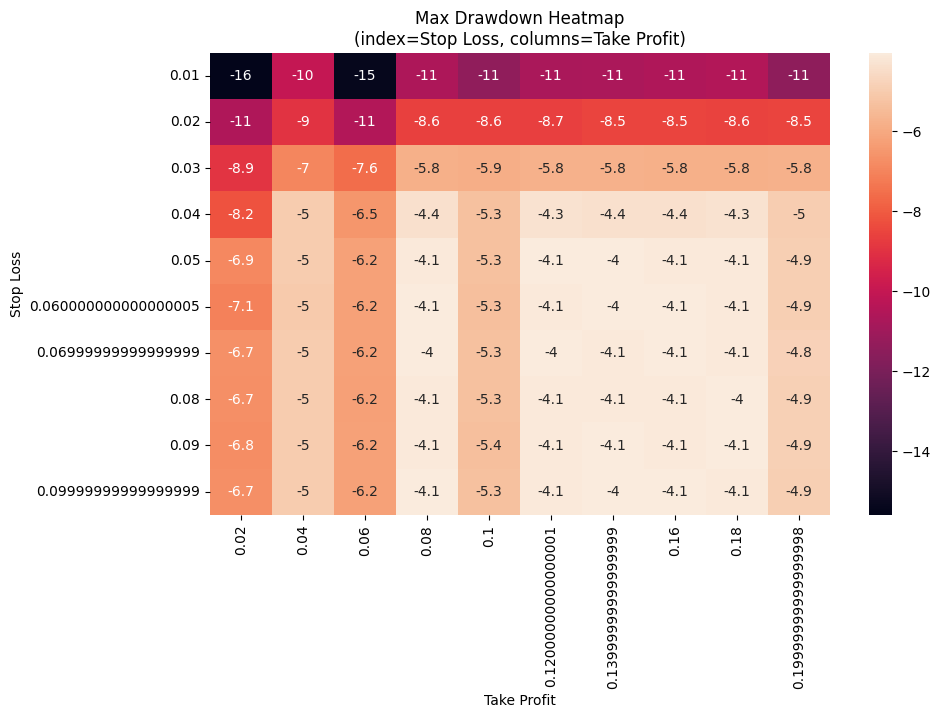

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

# 定義停損、停利的搜尋範圍
stop_losses = np.arange(0.01, 0.11, 0.01)   # 1% 到 10%
take_profits = np.arange(0.02, 0.21, 0.02)  # 2% 到 20%

# 建立 DataFrame 用來存最大回撤
heatmap_data = pd.DataFrame(index=stop_losses, columns=take_profits)

# Grid Search
for sl in tqdm(stop_losses):
    for tp in tqdm(take_profits):
        result = backtest_signals(
            df_signals.copy(),
            initial_capital=33,
            fee_rate=0.0005,
            leverage=1,
            allow_short=True,
            stop_loss=sl,
            take_profit=tp,
            capital_ratio=1,
            max_hold_bars=100000,
            delay_entry=True
        )
        # 假設 result['metric'] 裡有 'max_drawdown' 這個欄位
        max_dd = result['metric'].get('最大回撤', np.nan)
        heatmap_data.loc[sl, tp] = max_dd

# 繪製熱力圖
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data.astype(float), annot=True)  # 百分比顯示
plt.title('Max Drawdown Heatmap\n(index=Stop Loss, columns=Take Profit)')
plt.xlabel('Take Profit')
plt.ylabel('Stop Loss')
plt.show()

# 多幣種處理最佳化

100%|██████████| 100/100 [02:33<00:00,  1.54s/it]


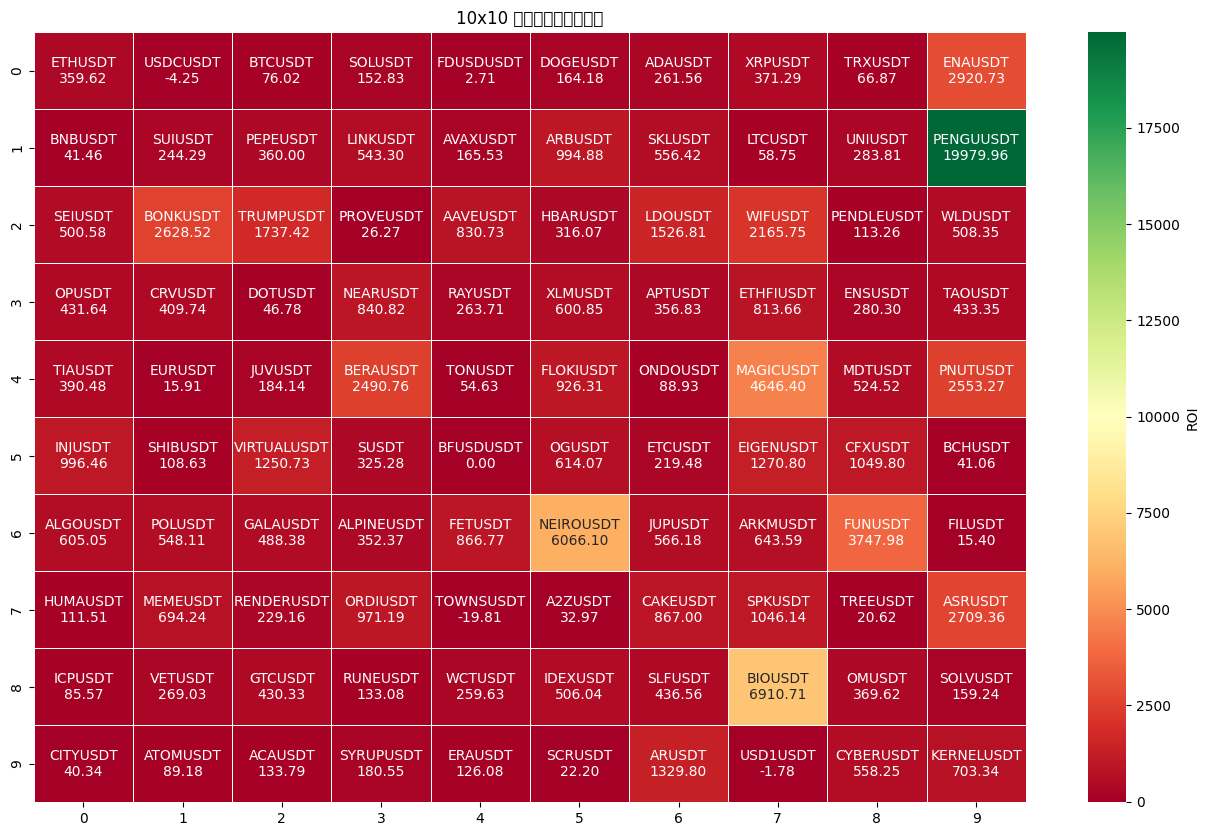

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from binance.client import Client
import pandas as pd
import time
import requests
import os
from Technicalindicatorstrategy import vegas
from datetime import datetime
from tqdm import tqdm
from dotenv import load_dotenv
load_dotenv()

# Binance API Key (可為空)
client = Client(api_key='', api_secret='')

# 取得成交量最高的 USDT 交易對，過濾掉 BULL/BEAR 等槓桿代幣。
def get_top_symbols(limit=100, quote_asset='USDT'):
    tickers = client.get_ticker()
    usdt_pairs = [
        t for t in tickers if t['symbol'].endswith(quote_asset)
        and not t['symbol'].endswith('BULLUSDT')
        and not t['symbol'].endswith('BEARUSDT')
    ]
    sorted_pairs = sorted(usdt_pairs, key=lambda x: float(x['quoteVolume']), reverse=True)
    return [t['symbol'] for t in sorted_pairs[:limit]]

symbols = get_top_symbols(limit=100)
metrics = {}

for symbol in tqdm(symbols):
    try:
        df_signals = turtle_strategy.get_signals(symbol,'4h',datetime.now(),6*30*6)

        result = backtest_signals(
            df_signals.copy(),
            initial_capital = 33, # 1000台幣
            fee_rate = 0.0005, # 合約手續費
            leverage = 1, # 槓桿
            allow_short = True, # 是否做空
            stop_loss = 0.05,       # 停損閾值，例如0.05代表5%
            take_profit = 0.18,     # 停利閾值
            capital_ratio = 1, # 每次使用的資金佔比
            max_hold_bars = 100000,# 最大持有K棒數
            delay_entry=True
            )  

        roi = result['metric']['總報酬率']
        metrics[symbol] = roi

    except Exception as e:
        print(f"Error processing {symbol}: {e}")
        metrics[symbol] = None  # 可以標記為None來區分異常值

# 轉換成 DataFrame 10x10
symbols_list = list(metrics.keys())
roi_list = list(metrics.values())

import numpy as np

df = pd.DataFrame({
    'Symbol': symbols_list,
    'ROI': roi_list
})

# 過濾掉 ROI 是 None 的幣種
clean_df = df.dropna(subset=['ROI']).reset_index(drop=True)

# 確保可以 reshape 成 10x10，先取前 100 筆有效資料
clean_df = clean_df.head(100)

# 建立 ROI 與標籤的矩陣
roi_matrix = clean_df['ROI'].values.reshape(10, 10).astype(float)

symbol_matrix = clean_df.apply(lambda row: f"{row['Symbol']}\n{row['ROI']}", axis=1).values.reshape(10, 10)

# 畫熱力圖
plt.figure(figsize=(16, 10))
sns.heatmap(roi_matrix, annot=symbol_matrix, fmt='', cmap='RdYlGn', linewidths=0.5, cbar_kws={'label': 'ROI'})
plt.title('10x10 幣種總報酬率熱力圖')
plt.show()